# Movie Recommendation System Project

This project aims to build a movie recommendation system for a streaming service that offers a wide variety of movies on their platform. The data used here was obtained from the latest movie lens dataset.

This notebook shows both Content Based and Collaborative Filtering Methods

# Data exploration and descriptive statistics

## Importing necessary libraries and packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from wordcloud import WordCloud, STOPWORDS

## Loading the datasets into pandas dataframe

In [2]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
links = pd.read_csv('data/links.csv')
tags = pd.read_csv('data/tags.csv')

## Taking a peek into the datasets and doing some mild preprocessing

I will only be using the movies, ratings and tags dataset in this notebook.

In [3]:
print(movies.info())
movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


No missing values found in the movies or ratings dataset and the variables are in a usable format

In [4]:
print(ratings.info())
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


I will be dropping the timestamp column from 'ratings' df because it is unnecessary to keep it

In [5]:
print(tags.info())
tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
#dropping the timestamp column because we don't need it
ratings = ratings.drop('timestamp', axis = 1)

Merging the movies and ratings dataframes for use later in this notebook

In [7]:
movie_ratings = pd.merge(movies, ratings)
movie_ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


## Descriptive Statistics

The descriptive statistics of the movies dataset below does not provide any useful information

In [8]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


An analysis of the descriptive statistics of ratings df shows that the minimum rating score is 0.5 and the maximum is 5.0. The mean rating score is ~3.5 with a standard deviation of ~1.04

In [9]:
ratings.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


# Data Visualizations

## Distribution of rating score in ratings df

Showing the distribution of ratings given in the ratings dataset. In the plot below, we see that the rating scale ranges from 0.5 to 5.0 with increments of 0.5. The most prevalent ratings given are 3.0, and 4.0 with 5.0 coming in third. We also see that people were less likely to give low ratings as evidenced by the low number of movies rated between 0.5 and 2.5.

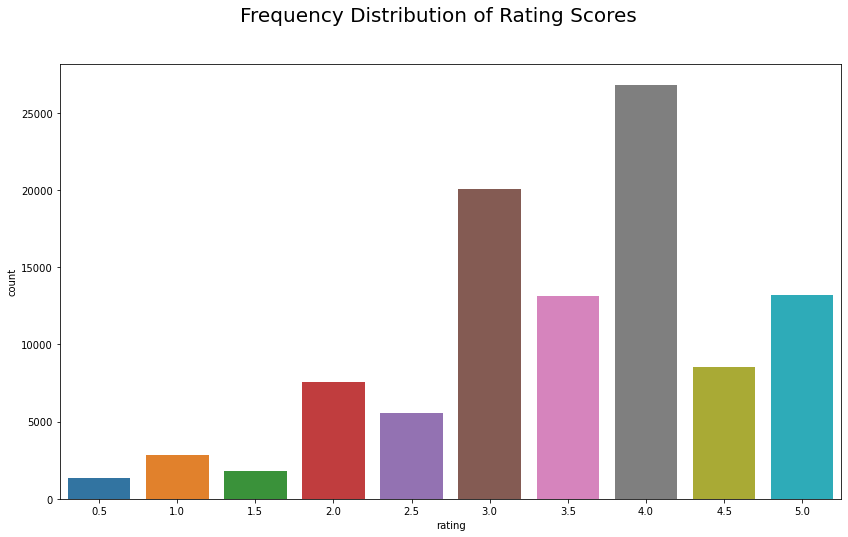

In [10]:
fig, ax = plt.subplots(figsize = (14,8))
sns.countplot(x = ratings.rating)
plt.suptitle('Frequency Distribution of Rating Scores', fontsize = 20)
fig.savefig('./images/FreqDistRating.png');

### Average Rating per Genre

The genres with the highest average ratings are Film-Noir, War and Documentary genres

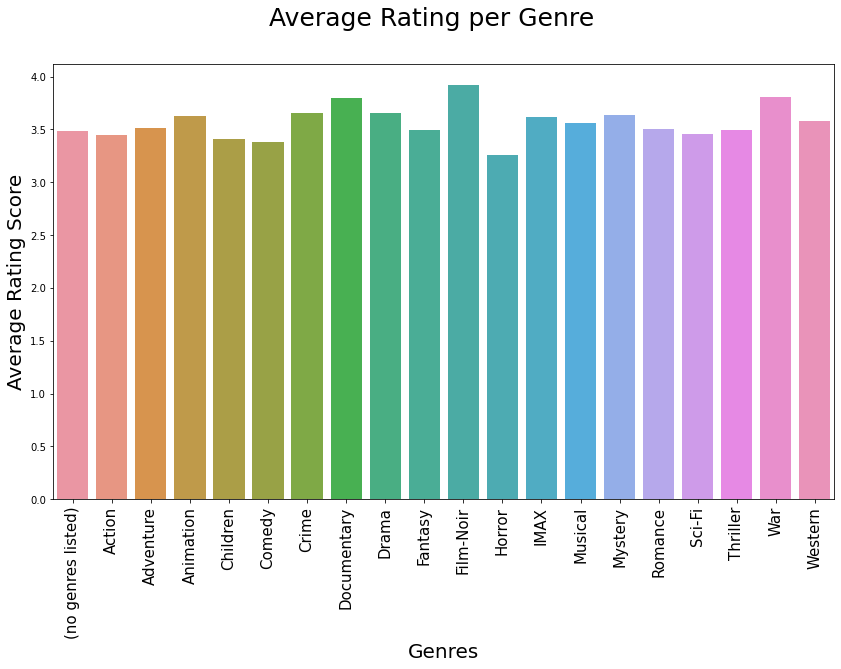

In [11]:
#subsetting the genres and rating columns from movie_ratings
genre_ratingdf = movie_ratings.loc[:,['genres', 'rating']]

# Unravel the genre columns
genre_ratingdf = genre_ratingdf.set_index(genre_ratingdf.columns.drop('genres',1).tolist()).genres.str.split('|', expand=True).stack().reset_index().rename(columns={0:'genres'}).loc[:, genre_ratingdf.columns]

# group by genres and their mean rating score and resetting the index
genre_mean_rating = pd.DataFrame(genre_ratingdf.groupby('genres')['rating'].mean()).reset_index()

# plotting the figure
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x = 'genres', y = 'rating', data = genre_mean_rating)

ax.tick_params(axis='x', labelsize= 15, rotation=90)
ax.set_xlabel('Genres', fontsize= 20)
ax.set_ylabel('Average Rating Score',fontsize= 20)
plt.suptitle('Average Rating per Genre', fontsize= 25)
fig.savefig('./images/AverageRatingPerGenre.png');

## Wordcloud showing most frequent words in the movie titles

From the wordcloud below, we can see that we have quite a few franchises in the dataset as evidenced by the bold lettering of 'II' and 'III'. We also have a lot of movies about 'love' apparently

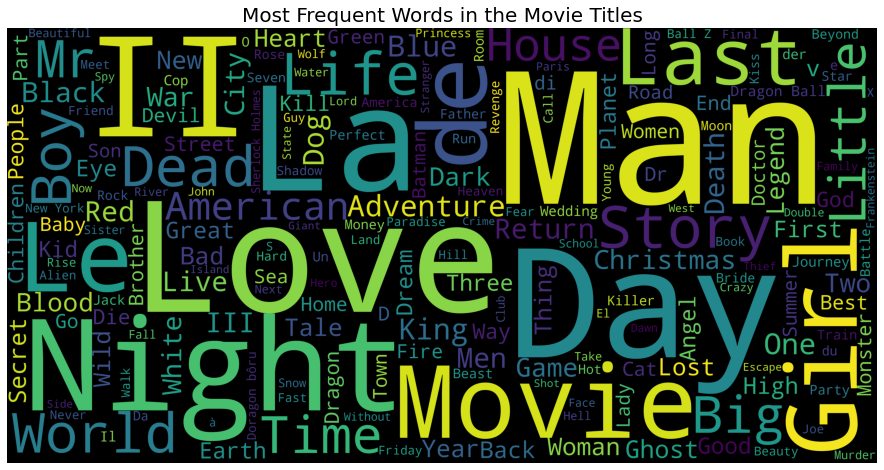

In [12]:
# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloud.png');

The function in the cell below gives us a frequency distribution of the genres in the movies df. We can see that Drama, Comedy, Thriller, Action and Romance are the most frequently mentioned genres in descending order.

In [13]:
# getting the census of the genre keywords
genre_labels = set()
for genre in movies['genres'].str.split('|').values:
    genre_labels.update(genre)

# Function that gets the frequency distribution of the genre keywords
def keyword_count(dataset, column, keywords):
    keyword_dict = {key:0 for key in keywords}
    for genre in dataset[column].str.split('|'):                
        for key in [key for key in genre if key in keywords]: 
            if pd.notna(key): 
                keyword_dict[key] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_dict.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_dict

# Calling this function gives access to a list of genre keywords which are sorted by descending order of frequency
keyword_occurences, keyword_dict = keyword_count(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

## Wordcloud below shows the prevalence of genres in the dataset.

Creating a bag of words for the genre keywords

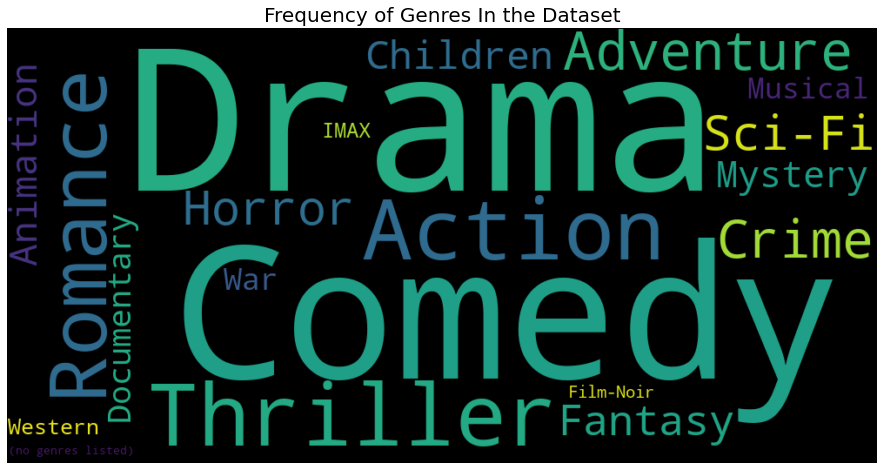

In [14]:
# Create the wordcloud of genres keywords
genre_wordcloud = WordCloud(width=1000,height=500, background_color='black')
genre_wordcloud.generate_from_frequencies(keyword_dict)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Frequency of Genres In the Dataset', fontsize = 20)
plt.show()
fig.savefig('./images/GenreCloud.png');

# Content Based

## Merging the movie_ratings df with the tags df

This is because I want to use the genres as well as the tags for the recommendation system 

In [15]:
mt_ratings = pd.merge(movie_ratings, tags).drop('timestamp', axis = 1)
mt_ratings.head()

,movieId,title,genres,userId,rating,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,4.0,pixar
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474,4.0,pixar
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567,3.5,fun
3,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,fantasy
4,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,magic board game


## Splitting each genre variable, removing the '|' symbol and converting them to lowercase

In [16]:
mt_ratings['genres'] = mt_ratings['genres'].apply(lambda x: ''.join(x.replace('|', ' ').lower()))
mt_ratings.head()

,movieId,title,genres,userId,rating,tag
0,1,Toy Story (1995),adventure animation children comedy fantasy,336,4.0,pixar
1,1,Toy Story (1995),adventure animation children comedy fantasy,474,4.0,pixar
2,1,Toy Story (1995),adventure animation children comedy fantasy,567,3.5,fun
3,2,Jumanji (1995),adventure children fantasy,62,4.0,fantasy
4,2,Jumanji (1995),adventure children fantasy,62,4.0,magic board game


## Creating a new column that takes in the features in genres and tag columns per row

In [17]:
def combined_features(row):
    return row['genres']+" "+row['tag']
mt_ratings["combined_features"] = mt_ratings.apply(combined_features, axis =1)
mt_ratings.sample(2)

,movieId,title,genres,userId,rating,tag,combined_features
2441,27156,Neon Genesis Evangelion: The End of Evangelion...,action animation drama fantasy sci-fi,184,4.5,end of the world,action animation drama fantasy sci-fi end of t...
2712,56367,Juno (2007),comedy drama romance,477,4.0,notable soundtrack,comedy drama romance notable soundtrack


In [18]:
#resetting the index of the dataframe
mt_ratings.reset_index(inplace = True)

## Making Recommendations based on the movie that a user likes

In this section I'm going to be importing a class that I created which uses CountVectorizer from sklearn.feature_extraction.text to transform the combined_features column in mt_ratings into a matrix of token counts and cosine_similarity from sklearn.metrics.pairwise to caluculate the cosine similarity on the vectorized column.

This class can be found in the contentbasedrec.py file in the same folder as this notebook.

When the class is instantiated, it takes in the name of the movie and the mt_ratings dataframe.

It returns a list of top fifteen movies with the highest cosine similarity to a given movie title and these are recommended to the user.

In [19]:
from contentbasedrec import ContentBasedRec
%load_ext autoreload
%autoreload 2

### Testing the recommendation system class

In [20]:
# This randomly produces a movie title from our dataset to ensure that we get the right name and to make sure that we 
# choose a movie that is in the dataset. Using random_state to ensure reproducible results.
mt_ratings.sample(1, random_state = 42)['title']

2069    Hulk (2003)
Name: title, dtype: object

In [21]:
movies_like_hulk  = ContentBasedRec('Hulk (2003)', mt_ratings)

In [22]:
movies_like_hulk.movie_list()

Here are a few recommendations for you


['Hulk (2003)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'X-Men (2000)',
 'Star Trek (2009)',
 'Terminator Salvation (2009)',
 'Avatar (2009)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Superman (1978)',
 'Superman III (1983)',
 'Star Wars: Episode III - Revenge of the Sith (2005)',
 'Fantastic Four (2005)',
 'Serenity (2005)',
 'Fantastic Four: Rise of the Silver Surfer (2007)',
 'Green Lantern (2011)']

# Collaborative Filtering

## Taking a look at the number of unique user ids and movie ids in the ratings df

In [23]:
# checking the unique number of user id and movie id in the ratings dataset
print(len(ratings['userId'].unique()), 'Number of user ids')
print(len(ratings['movieId'].unique()), 'Number of movie ids')

610 Number of user ids
9724 Number of movie ids


## Reading the dataset into 'surprise'

In [24]:
#reading in the range of ratings score
reader = Reader(rating_scale = (1,5))
#loading the dataframe into surprise
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

## Building the training set from the data

In [25]:
dataset = data.build_full_trainset()

## Modeling

 Trying various models to determine the best one

The accuracy metric that I will focus on in this project is going to be the rmse (root mean squared error). I will run a number of models and see which has the lowest rmse score. I will then use the best model moving forward

### Cross validation with KNN Basic Model

In [26]:
# using pearson correlation
knn_basic = KNNBasic(sim_options = {'name':'pearson', 'user_based':True})
cv_basic = cross_validate(knn_basic, data, n_jobs=-1)

for i in cv_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_basic['test_rmse']))

('test_rmse', array([0.9750914 , 0.96865652, 0.97588579, 0.97020475, 0.97314935]))
('test_mae', array([0.7533758 , 0.74838363, 0.75395412, 0.74814921, 0.7506498 ]))
('fit_time', (0.7293379306793213, 0.7527117729187012, 0.7159225940704346, 0.716749906539917, 0.7649803161621094))
('test_time', (1.6204655170440674, 1.5982513427734375, 1.602308750152588, 1.5785167217254639, 1.6089391708374023))
-----------------------
0.9725975624509913


### Cross_validation with KNNWithMeans

In [27]:
#cross_validation with knnwithmeans
knn_means = KNNWithMeans(sim_options={'name':'pearson', 'user_based':True})
cv_means = cross_validate(knn_means, data, n_jobs=-1)

for i in cv_means.items():
    print(i)
print('-----------------------')
print(np.mean(cv_means['test_rmse']))

('test_rmse', array([0.89895264, 0.90448337, 0.89562423, 0.89414485, 0.89152721]))
('test_mae', array([0.68653507, 0.68647962, 0.68105182, 0.68007102, 0.67748072]))
('fit_time', (0.7434401512145996, 0.8281939029693604, 0.736485481262207, 0.812934160232544, 0.7504408359527588))
('test_time', (1.8240904808044434, 1.8404431343078613, 1.760326623916626, 1.8812425136566162, 1.7793941497802734))
-----------------------
0.8969464595004741


### Cross validation with KNNBaseline

In [28]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_baseline = cross_validate(knn_baseline, data)

for i in cv_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_baseline['test_rmse']))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
('test_rmse', array([0.88471724, 0.88210656, 0.87734249, 0.87398484, 0.87404103]))
('test_mae', array([0.67254479, 0.6726058 , 0.67002876, 0.67105183, 0.66510089]))
('fit_time', (0.6056838035583496, 0.6087894439697266, 0.5866043567657471, 0.6055729389190674, 0.5834524631500244))
('test_time', (1.5624995231628418, 1.6607935428619385, 1.5691595077514648, 1.5700633525848389, 1.555316686630249))
-----------------------
0.8784384327383444


### GridSearch with SVD using different parameters

The cell below shows the different paramater used in some grid search. They are commented out because I'm only going to run the model that gave the lowest rmse score.

In [29]:
# grid = {'n_factors' : [20,100],'n_epochs' : [5,10], 'reg_all' : [0.4, 0.6], 
#               'lr_all' : [0.002, 0.005], }
# gs_model = GridSearchCV(SVD, param_grid = grid, n_jobs = -1)
# gs_model.fit(data)
# print('gs_model best parameters:','\n', gs_model.best_params)
# print('\n')
# print('gs_model best score:', gs_model.best_score)

# # --------------------------------------------------------------------------------------
# grid2 = {'n_factors' : [10,90],'n_epochs' : [10,20], 'reg_all' : [0.1, 0.4], 
#               'lr_all' : [0.005, 0.009], }
# gs_model2 = GridSearchCV(SVD, param_grid = grid2, n_jobs = -1)
# gs_model2.fit(data)

# print('gs_model2 best parameters:','\n',gs_model2.best_params)
# print('\n')
# print('gs_model2 best score:', gs_model2.best_score)

# # ---------------------------------------------------------------------------------------
# grid3 = {'n_factors' : [20,100],'n_epochs' : [20,30], 'reg_all' : [0.05, 0.1], 
#               'lr_all' : [0.009, 0.01], }
# gs_model3 = GridSearchCV(SVD, param_grid = grid3, n_jobs = -1)
# gs_model3.fit(data)

# print('gs_model3 best parameters:','\n',gs_model3.best_params)
# print('\n')
# print('gs_model3 best score:', gs_model3.best_score)

# #---------------------------------------------------------------------------------------
# grid4 = {'n_factors' : [20,100],'n_epochs' : [30,40], 'reg_all' : [0.1, 0.2], 
#               'lr_all' : [0.01, 0.05], }
# gs_model4 = GridSearchCV(SVD, param_grid = grid4, n_jobs = -1)
# gs_model4.fit(data)

# print('gs_model4 best parameters:','\n',gs_model4.best_params)
# print('\n')
# print('gs_model4 best score:', gs_model4.best_score)

In [30]:
grid5 = {'n_factors' : [20,100],'n_epochs' : [40,60], 'reg_all' : [0.1, 0.2], 
              'lr_all' : [0.01, 0.05], }
gs_model5 = GridSearchCV(SVD, param_grid = grid5, n_jobs = -1)
gs_model5.fit(data)

print('gs_model5 best parameters:','\n', gs_model5.best_params)
print('\n')
print('gs_model5 best score:', gs_model5.best_score)

gs_model5 best parameters: 
 {'rmse': {'n_factors': 100, 'n_epochs': 60, 'reg_all': 0.1, 'lr_all': 0.01}, 'mae': {'n_factors': 100, 'n_epochs': 60, 'reg_all': 0.1, 'lr_all': 0.01}}


gs_model5 best score: {'rmse': 0.8499554728935289, 'mae': 0.6508945761512515}


The model with the lowest rmse out of all the models is the SVD model with the best parameters printed out above in gs_model5 so we will use SVD with these parameters.

### Example prediction of ratings

In [31]:
svd = SVD(n_factors= 100, n_epochs = 60, reg_all=0.1, lr_all=0.01)
svd.fit(dataset)

In [32]:
svd.predict(2, 35)

Prediction(uid=2, iid=35, r_ui=None, est=3.577010076199492, details={'was_impossible': False})

## Making some recommendations using SVD

In [33]:
# movie_df is the df that contains the movie title, id and genres, num refer to the number of movie ratings required to 
# be given by the user
def movie_rater(movie_df,num, genre=None):
#     choosing 1000 to ensure we do not overwrite an already existing userid
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list 

In [34]:
# gets user ratings for movies the user has watched
user_rating = movie_rater(movies, 4, 'Drama')

      movieId                 title  \
4631     6902  Interstate 60 (2002)   

                                                 genres  
4631  Adventure|Comedy|Drama|Fantasy|Mystery|Sci-Fi|...  
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId           title                genres
2341     3099  Shampoo (1975)  Comedy|Drama|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId                   title        genres
8833   131920  The Road Within (2014)  Comedy|Drama
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId                                 title        genres
5023     7811  Babylon 5: The River of Souls (1998)  Drama|Sci-Fi
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3


In [35]:
# append the user_rating result to the end of the ratings df which has the userid, movieid, and ratings
new_ratings_df = ratings.append(user_rating,ignore_index=True)
# load into surprise
new_data = Dataset.load_from_df(new_ratings_df,reader)
# build the train data set
new_dataset = new_data.build_full_trainset()

In [36]:
# fit the svd model tot he new dataset
svd_ = SVD(n_factors= 100, n_epochs = 60, reg_all=0.1, lr_all=0.01)
svd_.fit(new_dataset)

In [37]:
# this creates a list of tuples (movie_id, predicted_rating) in descending order of rating score
list_of_movies = []
for movie_id in ratings['movieId'].unique():
    list_of_movies.append( (movie_id,svd_.predict(1000,movie_id)[3]))
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True) 

The function below takes in the ranked_movies from the result above, the movies dataframe and the number of movie recommendations desired by the user and returns the top five highly rated movie based on what out model predicted for the user

In [38]:
def recommended_movies(predicted_ratings,movie_title_df,n):
        for idx, rec in enumerate(predicted_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Here are 5 movies we recommend for you to watch:','\n')
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Here are 5 movies we recommend for you to watch: 

Recommendation #  1 :  5202    Jetée, La (1962)
Name: title, dtype: object 

Here are 5 movies we recommend for you to watch: 

Recommendation #  2 :  9170    World of Tomorrow (2015)
Name: title, dtype: object 

Here are 5 movies we recommend for you to watch: 

Recommendation #  3 :  4631    Interstate 60 (2002)
Name: title, dtype: object 

Here are 5 movies we recommend for you to watch: 

Recommendation #  4 :  4390    Belle époque (1992)
Name: title, dtype: object 

Here are 5 movies we recommend for you to watch: 

Recommendation #  5 :  3189    Rififi (Du rififi chez les hommes) (1955)
Name: title, dtype: object 

